In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import json
import pdb

from fastai.conv_learner import *
from fastai.dataset import *

from cycler import cycler
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
%matplotlib inline

## Load and Import all Files and Process Data

In [2]:
PATH = Path('data/pascal')
trn_j = json.load((PATH/'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]
JPEGS = 'JPEGImages'
IMG_PATH = PATH/JPEGS
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [3]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

In [5]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

## Model Run Train Predict

In [7]:
CSV=PATH/'tmp/lrg.csv'
MC_CSV = PATH/'tmp/mc.csv'
f_model = resnet34
sz=224
bs=64
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv('./', IMG_PATH, MC_CSV, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [8]:
lr = 2e-2
#learn.fit(lr, 1, cycle_len=2, use_clr=(32,5))

In [ ]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/10, 1, cycle_len=2, use_clr=(32,5))
learn.save('mclas')
learn.load('mclas')

In [9]:
def sigmoid(x, derivative=False):
      return x*(1-x) if derivative else 1/(1+np.exp(-x))
sigmoid(-0.63922)

0.34542288073631372

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


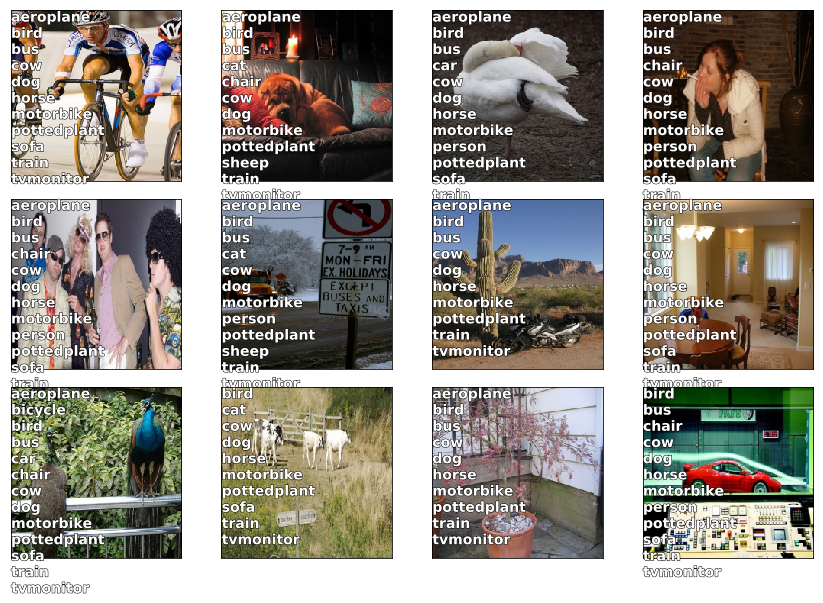

In [10]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Bounding Box Draw

In [11]:
MBB_CSV = PATH/'tmp/mbb.csv'
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv('./',IMG_PATH, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [12]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [13]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

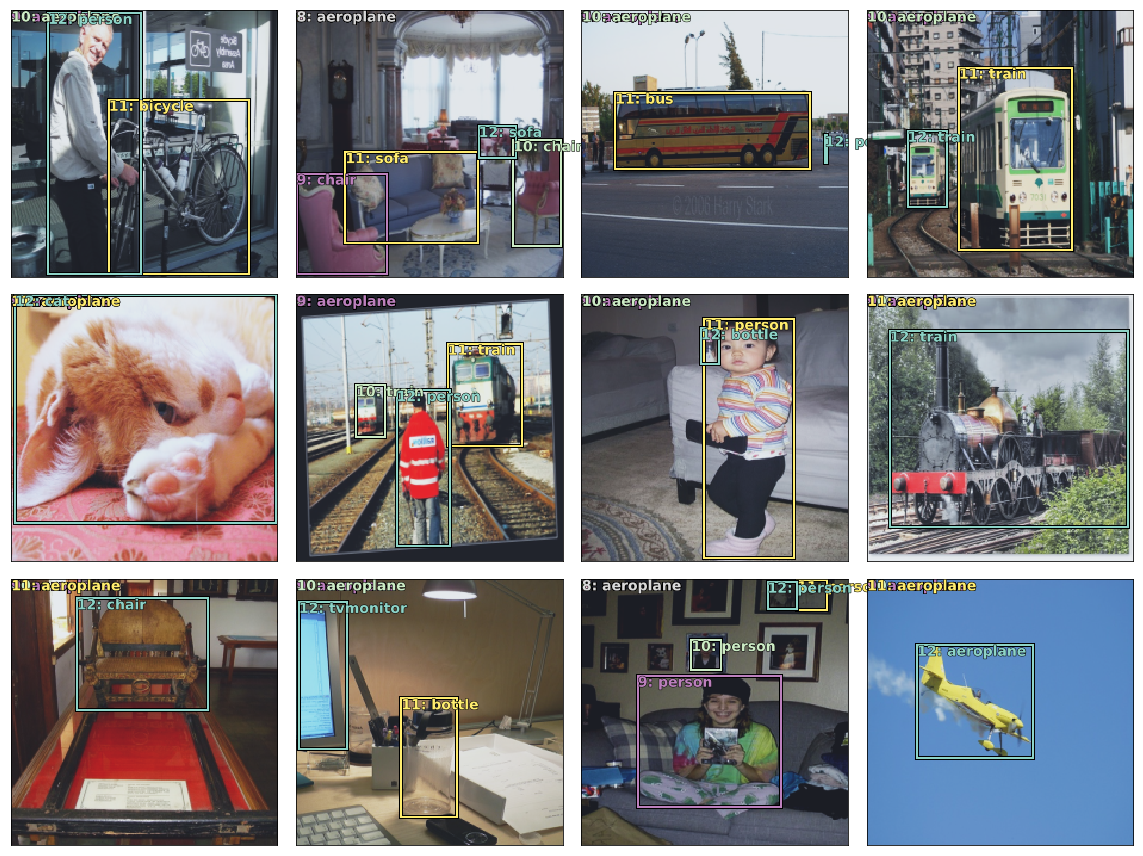

In [14]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2
x,y=to_np(next(iter(md.val_dl)))
x=sigmoid(np.rollaxis(x,1,4))
x,y=to_np(next(iter(md.trn_dl)))
x=sigmoid(np.rollaxis(x,1,4))
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()